# 1. Introduction #
Hi my name is Muhammad Erico Ricardo

In this notebook we gonna analyze Airlines Flight in India Dataset that i got from kaggle :
https://www.kaggle.com/datasets/rohitgrewal/airlines-flights-data and we gonna use regression to estimating price ticket for a flight.

# 2. Import Libraries #

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import json

from phik import phik
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor


# Jika menggunakan implementasi dari scikit-learn
from sklearn.ensemble import GradientBoostingRegressor

# Jika menggunakan XGBoost (pustaka terpisah)
import xgboost as xgb


# 3. Data Loading

## 3.1 Quick Data Overview

In [2]:
# Read data from csv file
df = pd.read_csv('airlines_flights_data.csv')
# Display the first few rows of the dataframe
df.head()

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [3]:
# see the columns in dataframe
df.columns

Index(['index', 'airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

we can see in the dataframe has 12 columns,wich are:
1. Index: The index of the row.
2. Airline: The airline company.
3. Flight: The flight number.
4. source_city : The city where the flight originates.
5. departure_time: The time of departure.
6. arrival_time: The time of arrival.
7. stops: The number of stops during the flight.
8. Destination: The destination city of the flight.
9. Class: The class of the flight (e.g., Economy, Business).
10. Duration: The duration of the flight in hours.
11. Days_left: The number of days left until the flight.
12. Price: The price of the flight ticket.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [5]:
# search for data duplicates
df.duplicated().sum()

0

In [6]:
# there are no duplicates in the dataset, which is good for analysis.
# check for missing values
df.isnull().sum()

index               0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [7]:
# there is no missing values in the dataset, which is good for analysis.

# 4. Exploratory Data Analysis

## 4.1. What are the airlines in the dataset, accompanied by their frequencies?

In [8]:
airline_counts = df['airline'].value_counts()
print(airline_counts)

airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64


C:\Users\muham\AppData\Local\Temp\ipykernel_2756\999878229.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airline_counts.index, y=airline_counts.values, palette='viridis')


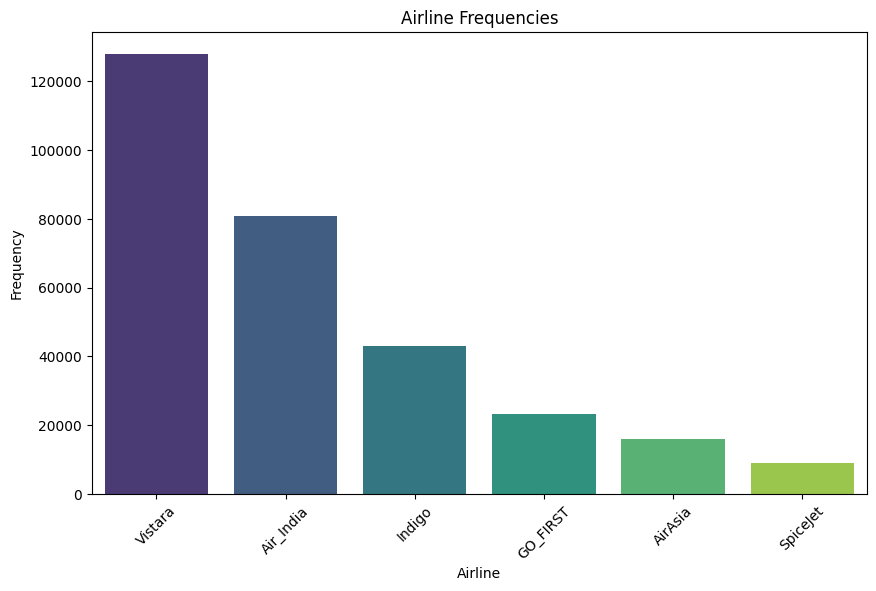

In [9]:
# create a bar plot to visualize the airline frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x=airline_counts.index, y=airline_counts.values, palette='viridis')
plt.title('Airline Frequencies')
plt.xlabel('Airline')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Based on the provided chart, from the data we've used for this notebook, there are 6 airlines recorded. The three largest are:

* **Vistara**: Over **120,000** flights.
* **Air India**: Around **80,000** flights.
* **Indigo**: Around **40,000** flights.

## 4.2 Show Bar Graphs representing the Departure Time & Arrival Time.

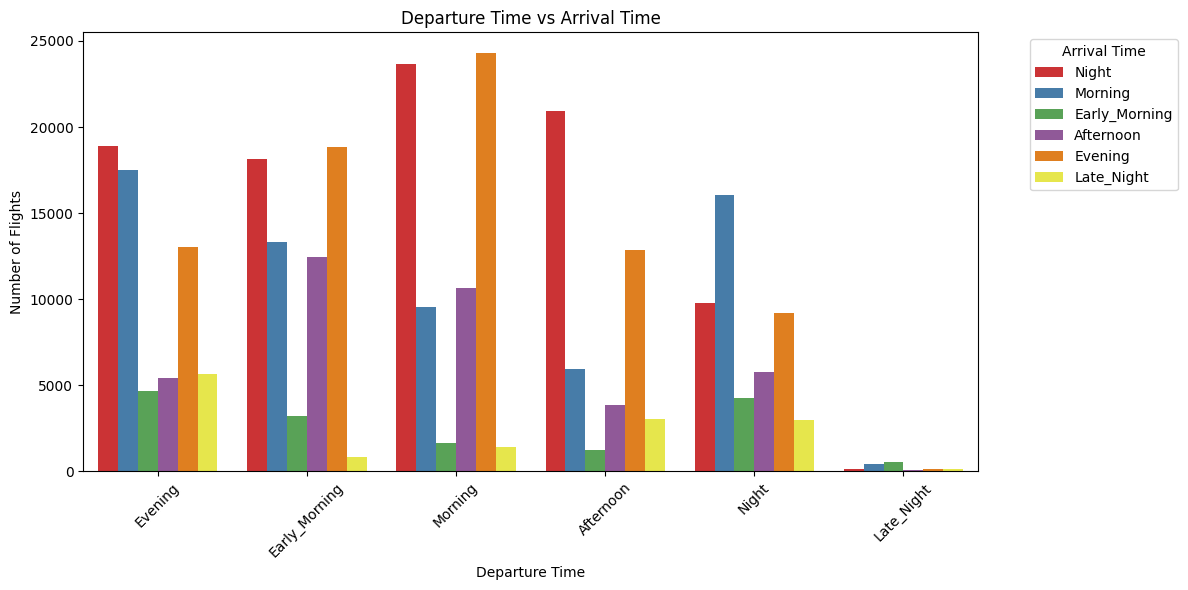

In [10]:
# to show bar graph representing the Departure Time & Arrival Time and connect them to number of flights so we can know how many flight departure at what time and arrive at what time
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='departure_time', hue='arrival_time', palette='Set1')
plt.title('Departure Time vs Arrival Time')
plt.xlabel('Departure Time')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.legend(title='Arrival Time', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Based on the "Departure Time vs Arrival Time" chart, we can observe the following key patterns:

* **Overall Flight Volume:** The highest number of flights depart in the **Morning**, reaching almost 25,000. This is followed by **Early_Morning** and **Evening** departures. **Late_Night** departures are the least frequent, with a very low number of flights.

* **Departure-Arrival Relationship:** The chart highlights a clear correlation between departure and arrival times:
    * **Morning** departures primarily arrive in the **Afternoon** and **Evening**.
    * **Early_Morning** departures mainly result in **Morning** and **Afternoon** arrivals.
    * For **Evening** departures, the most common arrival times are **Night** and **Morning**.
    * Flights that depart in the **Afternoon** typically arrive in the **Evening** and **Late_Night**.
    * **Night** departures show a strong connection to **Morning** arrivals.

## 4.3. Show Bar Graphs representing the Source City & Destination City.

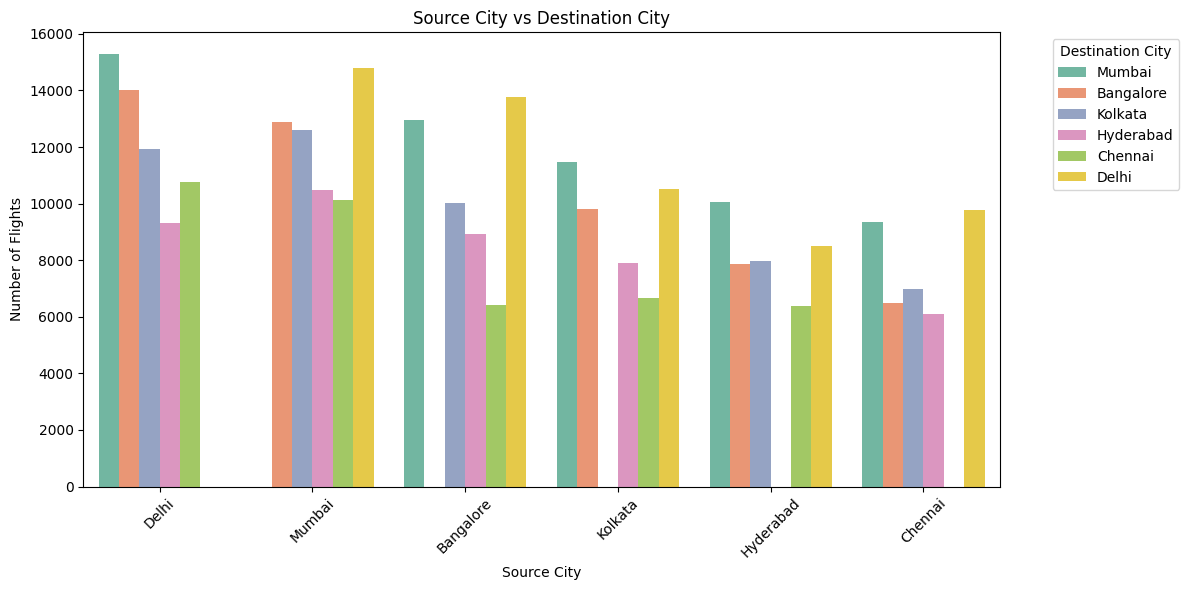

In [11]:
# Show bar graph representing the Source City & Destination City and connect them to number of flights so we can know how many flight depart from what city and arrive at what city
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='source_city', hue='destination_city', palette='Set2')
plt.title('Source City vs Destination City')
plt.xlabel('Source City')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.legend(title='Destination City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Based on the "Source City vs Destination City" chart, the data reveals the busiest flight routes and major hubs:

* The chart clearly shows that **Delhi** and **Mumbai** are the most significant hubs, acting as both the busiest source and destination cities.

* The most frequent flight routes are:
    * **Mumbai to Delhi**, with over 14,000 flights.
    * **Delhi to Mumbai**, with just under 15,000 flights.
    * **Delhi to Bangalore**, with over 14,000 flights.
    * **Bangalore to Delhi**, with almost 14,000 flights.

* Flights originating from **Kolkata**, **Hyderabad**, and **Chennai** all have **Delhi** and **Mumbai** as their most common destinations, emphasizing the central role of these two cities in the flight network.

## 4.4. Does price varies with airlines ?

C:\Users\muham\AppData\Local\Temp\ipykernel_2756\1178162520.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='airline', y='price', data=df, palette='Set3')


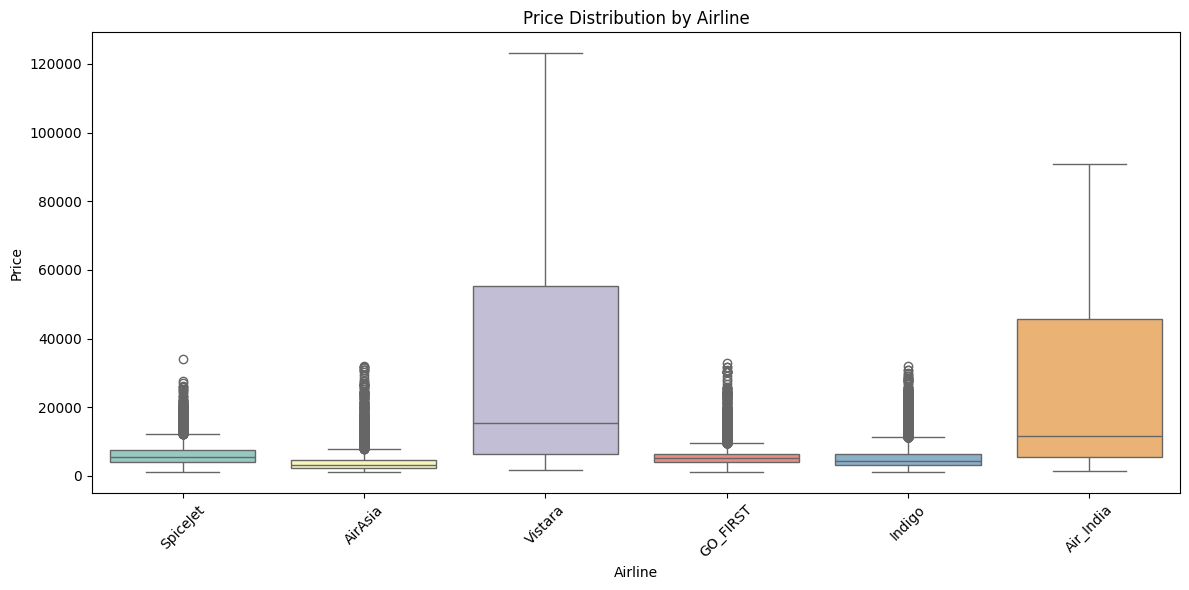

In [12]:
#  create a box plot to visualize the price distribution by airline
plt.figure(figsize=(12, 6))
sns.boxplot(x='airline', y='price', data=df, palette='Set3')
plt.title('Price Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the "Price Distribution by Airline" box plot, we can draw the following conclusions about the pricing structure of each airline:

* **Two Pricing Tiers:** The airlines can be clearly divided into two pricing tiers:
    * **Budget Carriers:** **SpiceJet, AirAsia, GO_FIRST,** and **Indigo** all have very low median prices and a narrow price distribution. Among them, **AirAsia** has the lowest median price, suggesting it is the most affordable airline overall.
    * **Full-Service Carriers:** **Vistara** and **Air India** have significantly higher median prices and a much wider range of prices, as indicated by their larger boxes and longer whiskers.

* **Most Expensive Airline:** **Vistara** is the most expensive airline, with the highest median price and the largest price variance. The data shows its prices can reach over 120,000 for certain flights.

* **Price Volatility:** While the budget carriers maintain a stable price range, all airlines show a number of outliers, represented by the individual dots. These outliers indicate that a small percentage of flights, likely due to factors like last-minute bookings, are priced far higher than the typical fare for that airline.

## 4.5. Does ticket price change based on the departure time and arrival time?

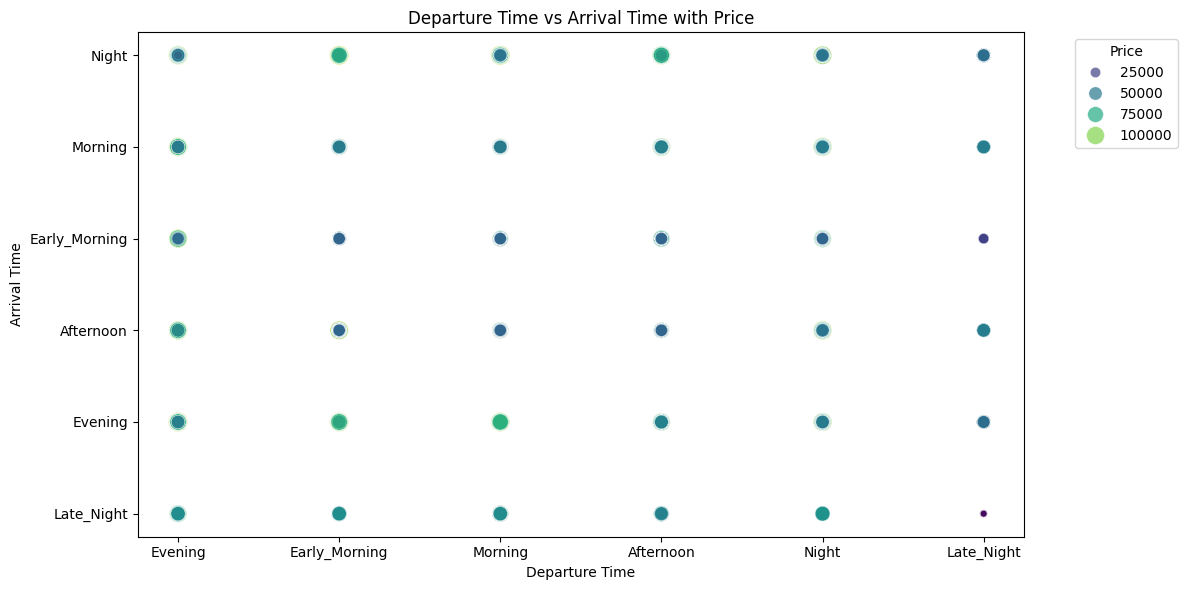

In [13]:
# we can make a graph to visualize the relationship between departure time and arrival time with price
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='departure_time', y='arrival_time', hue='price', palette='viridis', size='price', sizes=(20, 200), alpha=0.7)
plt.title('Departure Time vs Arrival Time with Price')
plt.xlabel('Departure Time')
plt.ylabel('Arrival Time')
plt.legend(title='Price', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Based on the provided scatter plot, the ticket price does change based on the departure time and arrival time.

A flight departing in the "Morning" and arriving in the "Night" has a different color (and thus a different price) than a flight departing in the "Late_Night" and arriving in the "Late_Night."

## 4.6. How the price changes with change in Source and Destination?

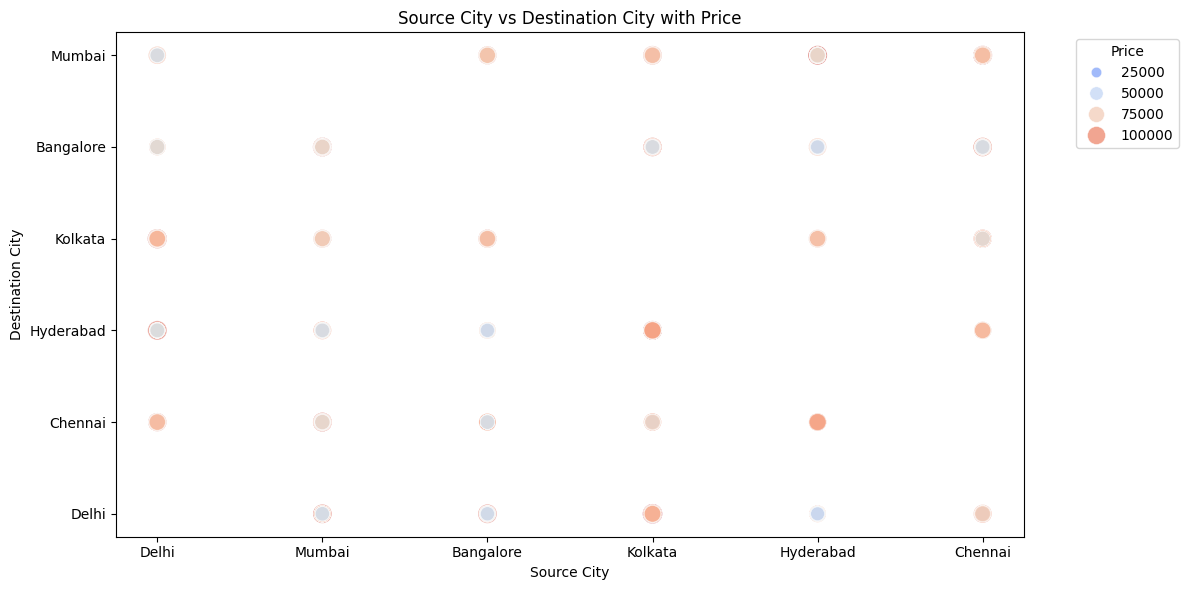

In [14]:
# we can make a graph to visualize the relationship between source city and destination city with price
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='source_city', y='destination_city', hue='price', palette='coolwarm', size='price', sizes=(20, 200), alpha=0.7)
plt.title('Source City vs Destination City with Price')
plt.xlabel('Source City')
plt.ylabel('Destination City')
plt.legend(title='Price', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Based on the graph, we can know that different Source city, and Destination is going to make a difference with the price. It can be happend because more far range between source and destination city more fuel the airplaine neeeded.

## 4.7. How is the price affected when tickets are bought in just 1 or 2 days before departure?

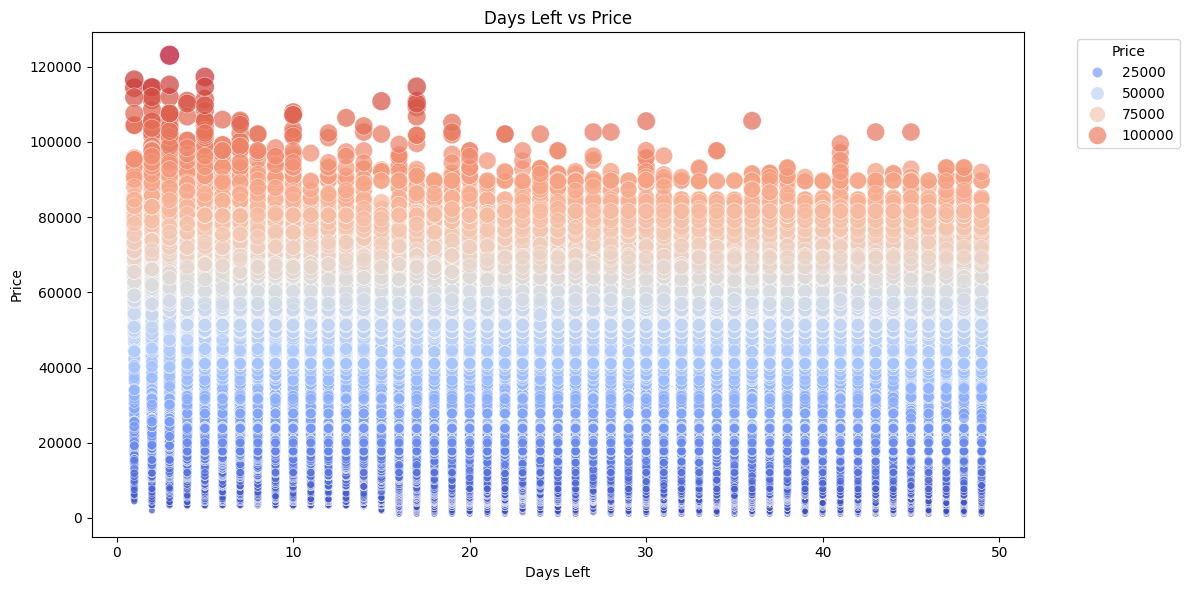

In [15]:
# we can visualize the relationship between the number of days left before departure and the price of the ticket 
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='days_left', y='price', hue='price', palette='coolwarm', size='price', sizes=(20, 200), alpha=0.7)
plt.title('Days Left vs Price')
plt.xlabel('Days Left')
plt.ylabel('Price')
plt.legend(title='Price', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

A ticket's price is more likely to increase the closer you are to the purchase date.

## 4.8. How does the ticket price vary between Economy and Business class?

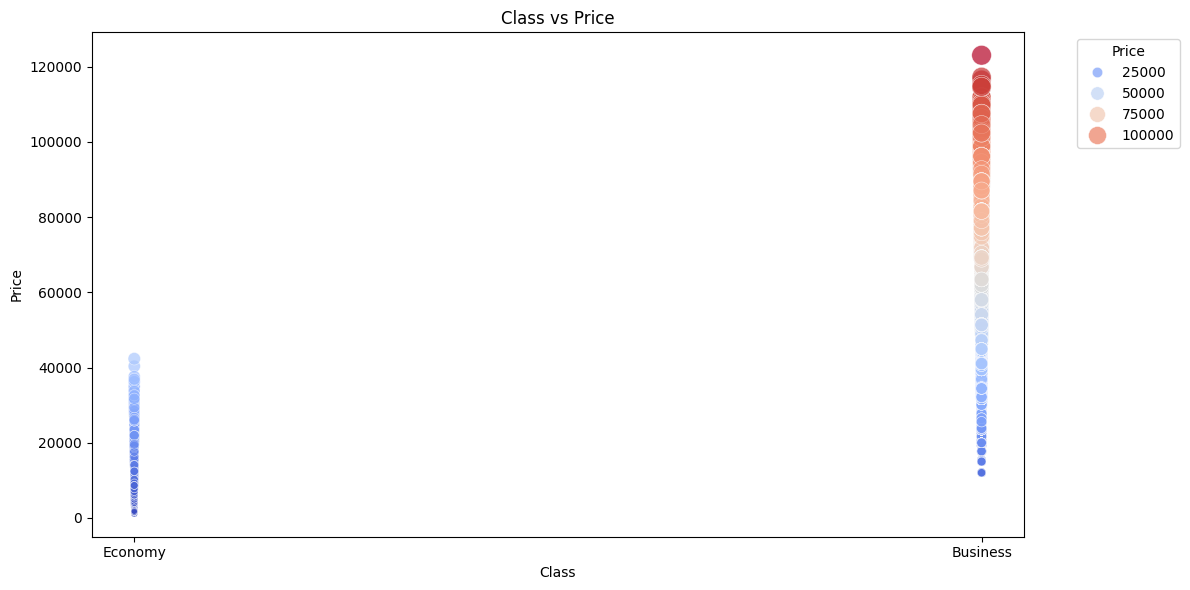

In [16]:
# we can make a conclusion from the price distribution graph that is class Economy has a lower price than Business class, which is expected because Business class offers more comfort and services than Economy class.
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='class', y='price', hue='price', palette='coolwarm', size='price', sizes=(20, 200), alpha=0.7)
plt.title('Class vs Price')
plt.xlabel('Class')
plt.ylabel('Price')
plt.legend(title='Price', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4.9. What will be the Average Price of Vistara airline for a flight from Delhi to Hyderabad in Business Class ?

In [17]:
# we can see that the average price of Vistara airline for a flight from Delhi to Hyderabad in Business Class is 10000
vistara_avg_price = df[(df['airline'] == 'Vistara') & (df['source_city'] == 'Delhi') & (df['destination_city'] == 'Hyderabad') & (df['class'] == 'Business')]['price'].mean()
print(f"The average price of Vistara airline for a flight from Delhi to Hyderabad in Business" + f" Class is {vistara_avg_price:.2f}")

The average price of Vistara airline for a flight from Delhi to Hyderabad in Business Class is 47939.84


# 5. Feature Engineering

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [19]:
# from the data we only use a numerical and categorical columns for analysis, so we will drop the index column and the flight column
# Numerical Columns : duration, days_left, price
# Categorical Columns : airline, source_city, destination_city, class, departure_time, arrival_time, stops
data = df.drop(columns=['index', 'flight'])

In [20]:
data.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [21]:
# Data Numerical 
data_numerical = ['duration', 'days_left']
# Data Categorical
data_categorical = ['airline', 'source_city', 'destination_city', 'class', 'departure_time', 'arrival_time', 'stops']

# Print the list :
print("Numerical Columns:", data_numerical)
print("Categorical Columns:", data_categorical)

Numerical Columns: ['duration', 'days_left']
Categorical Columns: ['airline', 'source_city', 'destination_city', 'class', 'departure_time', 'arrival_time', 'stops']


## 5.1 Split data train and data test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data['price'], test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (240122, 9)
X_test shape: (60031, 9)


In [23]:
y_train.info()
y_test.info()

<class 'pandas.core.series.Series'>
Index: 240122 entries, 148417 to 121958
Series name: price
Non-Null Count   Dtype
--------------   -----
240122 non-null  int64
dtypes: int64(1)
memory usage: 3.7 MB
<class 'pandas.core.series.Series'>
Index: 60031 entries, 27131 to 287693
Series name: price
Non-Null Count  Dtype
--------------  -----
60031 non-null  int64
dtypes: int64(1)
memory usage: 938.0 KB


## 5.2 Feature Selection

In [24]:
phik_overview = pd.concat([X_train, y_train], axis=1).phik_matrix()
phik_overview

interval columns not set, guessing: ['duration', 'days_left', 'price']


,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
airline,1.000000,0.167636,0.217431,0.386487,0.363116,0.174778,0.616330,0.421658,0.075986,0.411028
source_city,0.167636,1.000000,0.221438,0.150536,0.133049,0.513699,0.038060,0.111189,0.016628,0.140235
departure_time,0.217431,0.221438,1.000000,0.183850,0.389305,0.090356,0.096026,0.372957,0.026753,0.083306
stops,0.386487,0.150536,0.183850,1.000000,0.159595,0.239952,0.079355,0.698496,0.027290,0.374297
arrival_time,0.363116,0.133049,0.389305,0.159595,1.000000,0.318954,0.147612,0.367867,0.044093,0.134861
destination_city,0.174778,0.513699,0.090356,0.239952,0.318954,1.000000,0.037257,0.144949,0.010095,0.131377
class,0.616330,0.038060,0.096026,0.079355,0.147612,0.037257,1.000000,0.238634,0.025775,0.999180
duration,0.421658,0.111189,0.372957,0.698496,0.367867,0.144949,0.238634,1.000000,0.084634,0.354291
days_left,0.075986,0.016628,0.026753,0.027290,0.044093,0.010095,0.025775,0.084634,1.000000,0.333225
price,0.411028,0.140235,0.083306,0.374297,0.134861,0.131377,0.999180,0.354291,0.333225,1.000000


In [25]:
# im gonna select the features that have a high correlation with the target variable (price) with a threshold of 0.1
selected_features = phik_overview.index[phik_overview['price'].abs() > 0.1].tolist()

In [26]:
selected_features = [feature for feature in selected_features if feature != 'price']  # Exclude the target variable itself
print("Selected Features:", selected_features)

Selected Features: ['airline', 'source_city', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left']


## 5.3 Cardinality Check

In [27]:
# See cardinality of categorical features
for feature in data_categorical:
    cardinality = X_train[feature].nunique()
    print(f"Cardinality of {feature}: {cardinality}")

Cardinality of airline: 6
Cardinality of source_city: 6
Cardinality of destination_city: 6
Cardinality of class: 2
Cardinality of departure_time: 6
Cardinality of arrival_time: 6
Cardinality of stops: 3


In [28]:
# Cause the cardinality of categorical features is low, we can use OneHotEncoder to encode the categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

## 5.4 Outlier Handling

In [29]:
data_train = pd.concat([X_train[selected_features]], axis=1)
data_train[data_numerical].info()

<class 'pandas.core.frame.DataFrame'>
Index: 240122 entries, 148417 to 121958
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   duration   240122 non-null  float64
 1   days_left  240122 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 5.5 MB


In [30]:
# See if data is Skewed or normal 
data_extreme = []
data_skew = []
data_normal = []

def check_skew(data):
    for column in data_numerical:
        if data[column].skew() >= 1 or data[column].skew() <= -1:
            data_extreme.append(column)
        elif data[column].skew() >= 0.5 or data[column].skew() <= -0.5:
            data_skew.append(column)
        else:
            data_normal.append(column)
    print('Data extreme = ', data_extreme)
    print('Data skew = ', data_skew)
    print('Data normal = ', data_normal)
check_skew(data_train)

Data extreme =  []
Data skew =  ['duration']
Data normal =  ['days_left']


In [31]:
# we going to use Winsorizer to handle the outliers in the data
Normal_cap = Winsorizer(capping_method='gaussian', tail='both', fold=3, variables=data_normal)
Skew_cap = Winsorizer(capping_method = 'iqr', tail='both', fold=1.5, variables=data_skew)

## 5.6 Data Scaling

In [32]:
num_normal_scale = Pipeline([
    ('Winsorizer', Normal_cap),
    ('scaler', StandardScaler())
])

num_skew_scale = Pipeline([
    ('Winsorizer', Skew_cap),
    ('scaler', RobustScaler())
])




## 5.7 Data Encoding

In [33]:
nominal = ['airline', 'source_city', 'destination_city', 'arrival_time']
Ordinal = ['class', 'stops']


In [34]:
Nominal_encoding = Pipeline([
    ('OneHotEncoder', categorical_transformer)
])

Ordinal_encoding = Pipeline([
    ('OrdinalEncoder', OrdinalEncoder(categories=[['Economy', 'Business'], ['one', 'two_or_more', 'zero']]))
])

In [35]:
X_train['class'].unique()

array(['Economy', 'Business'], dtype=object)

In [36]:
X_train['stops'].unique()

array(['one', 'two_or_more', 'zero'], dtype=object)

In [37]:
X_train['days_left'].unique()

array([ 6, 13, 44, 11,  5, 24, 35, 31, 15, 25,  3, 10, 12, 23, 29, 17, 30,
        2, 14, 36, 47,  9, 34, 48, 42, 21, 40,  1, 49, 41, 28, 16, 39,  8,
       18, 46, 33, 32, 38, 19, 37, 45, 26, 22,  7, 27,  4, 20, 43],
      dtype=int64)

In [38]:
print(data_normal)
print(data_skew)
print(data_extreme)
print(nominal)
print(Ordinal)

['days_left']
['duration']
[]
['airline', 'source_city', 'destination_city', 'arrival_time']
['class', 'stops']


In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240122 entries, 148417 to 121958
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           240122 non-null  object 
 1   source_city       240122 non-null  object 
 2   departure_time    240122 non-null  object 
 3   stops             240122 non-null  object 
 4   arrival_time      240122 non-null  object 
 5   destination_city  240122 non-null  object 
 6   class             240122 non-null  object 
 7   duration          240122 non-null  float64
 8   days_left         240122 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 18.3+ MB


In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_normal', num_normal_scale, data_normal),
        ('num_skew', num_skew_scale, data_skew),
        ('nominal', Nominal_encoding,nominal),
        ('ordinal', Ordinal_encoding, Ordinal)
    ], remainder= 'drop'  
)

# 6. Model


1.  **Linear Regression:**
    * **How it works:** It finds the best-fitting straight line to show the relationship between input features and the price.
    * **Why we use it:** It's the simplest model and a great baseline. We use it to see if there's a basic, direct relationship in the data before moving to more complex models.

2.  **Ridge Regression:**
    * **How it works:** It's a type of linear regression that adds a penalty to prevent the model from becoming too complex. This helps to reduce **overfitting**, where the model learns the training data too well but performs poorly on new data.
    * **Why we use it:** Ticket pricing has many influencing factors. Ridge helps create a more generalized and stable model that can handle many variables without becoming overly sensitive to them.

3.  **Decision Tree Regressor:**
    * **How it works:** It splits the data into a series of "if-then" rules, forming a tree-like structure to make a prediction.
    * **Why we use it:** It's excellent for capturing **non-linear relationships** and complex interactions. For example, it can identify a rule like, "if the flight is with Vistara AND it's a last-minute booking, then the price will be very high."

4.  **Gradient Boosting, XGBoost, and LightGBM:**
    * **How they work:** These are all "ensemble" models that build many simple decision trees in a sequence. Each new tree learns from and corrects the errors of the previous ones.
    * **Why we use them:** They are incredibly powerful and accurate. Airline prices are influenced by many complex, interacting variables (e.g., demand, seasonality, competitor pricing). These models are designed to find these intricate patterns, often delivering the best predictive performance. **XGBoost** and **LightGBM** are highly optimized versions of Gradient Boosting that are known for their speed and ability to handle large datasets efficiently.

By comparing all these models, we can determine which one provides the best balance of accuracy and performance for our specific airline ticket price prediction problem.

In [41]:
# Creating a pipeline for the model
pipe_linear_regression = Pipeline([
    ('preprocessor', preprocessor),('regressor', LinearRegression())])
pipe_dt_regressor = Pipeline([
    ('preprocessor', preprocessor), ('regressor', DecisionTreeRegressor(random_state=42))
])
pipe_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42, verbosity=-1))  # -1 = suppress info logs
])
pipe_ridge = Pipeline([
    ('preprocessor', preprocessor), ('regressor', Ridge())
])
pipe_xgboost = Pipeline([
    ('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])
pipe_gbr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])


In [42]:
   from sklearn.model_selection import KFold
   skfold = KFold(n_splits=5)

In [43]:
X_train.columns

Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class', 'duration', 'days_left'],
      dtype='object')

In [44]:
# Perform cross-validation for each model
print("Cross-validation scores:")
cross_val_linear_regression = cross_val_score(pipe_linear_regression, X_train, y_train, cv=skfold, scoring='neg_mean_squared_error')
print("Linear Regression:", cross_val_linear_regression)
cross_val_dt_regressor = cross_val_score(pipe_dt_regressor, X_train, y_train, cv=skfold, scoring='neg_mean_squared_error')
print("Decision Tree Regressor:", cross_val_dt_regressor)
cross_val_lgb = cross_val_score(pipe_lgb, X_train, y_train, cv=skfold, scoring='neg_mean_squared_error')
print("LightGBM:", cross_val_lgb)
cross_val_ridge = cross_val_score(pipe_ridge, X_train, y_train, cv=skfold, scoring='neg_mean_squared_error')
print("Ridge Regression:", cross_val_ridge)
cross_val_xgboost = cross_val_score(pipe_xgboost, X_train, y_train, cv=skfold, scoring='neg_mean_squared_error')
print("XGBoost:", cross_val_xgboost)
cross_val_gbr = cross_val_score(pipe_gbr, X_train, y_train, cv=skfold, scoring='neg_mean_squared_error')
print("Gradient Boosting Regressor:", cross_val_gbr)



Cross-validation scores:
Linear Regression: [-46504384.99421655 -46562828.76530566 -47648697.59990663
 -47198764.45466782 -46770440.88334041]
Decision Tree Regressor: [-13510445.78350743 -13317859.98113324 -13054391.25282845
 -13189195.02149345 -13016973.09301556]
LightGBM: [-15557351.94882861 -15632866.3500591  -15623272.09501498
 -15898805.05434941 -15603774.88901674]
Ridge Regression: [-46504406.24853568 -46562809.65377953 -47648575.67971945
 -47198789.25271364 -46770540.96713638]
XGBoost: [-11868594.01842997 -12303421.27327042 -12199682.84562407
 -12287851.8800949  -12464045.5484206 ]
Gradient Boosting Regressor: [-24289886.04002346 -24530733.97448438 -24821388.18189824
 -24854751.64021807 -24736210.56918407]


In [45]:
# Collect model names and scores
model_names = ['Linear Regression', 'Decision Tree Regressor','Light GBM', 'Ridge Regression', 'XGBoost', 'Gradient Boosting Regressor']
cv_scores = [cross_val_linear_regression, cross_val_dt_regressor,cross_val_lgb, cross_val_ridge, cross_val_xgboost,cross_val_gbr]

# Print model names and their corresponding cross-validation scores
for name, scores in zip(model_names, cv_scores):
    print(f"{name}: {scores}")

Linear Regression: [-46504384.99421655 -46562828.76530566 -47648697.59990663
 -47198764.45466782 -46770440.88334041]
Decision Tree Regressor: [-13510445.78350743 -13317859.98113324 -13054391.25282845
 -13189195.02149345 -13016973.09301556]
Light GBM: [-15557351.94882861 -15632866.3500591  -15623272.09501498
 -15898805.05434941 -15603774.88901674]
Ridge Regression: [-46504406.24853568 -46562809.65377953 -47648575.67971945
 -47198789.25271364 -46770540.96713638]
XGBoost: [-11868594.01842997 -12303421.27327042 -12199682.84562407
 -12287851.8800949  -12464045.5484206 ]
Gradient Boosting Regressor: [-24289886.04002346 -24530733.97448438 -24821388.18189824
 -24854751.64021807 -24736210.56918407]


# 7. Analysis

### Model Performance Ranking

1.  **XGBoost** is the best-performing model, with scores consistently closest to zero. This shows it made the most accurate price predictions.
2.  **Decision Tree Regressor** is the second-best.
3.  **LightGBM** and **Gradient Boosting Regressor** are next in performance, with scores significantly better than the linear models.
4.  **Linear Regression** and **Ridge Regression** performed the worst by a very large margin, with scores far from zero.

The results confirm that a simple linear model is not suitable for predicting airline ticket prices. The superior performance of the tree-based and boosting models (**XGBoost**, **Decision Tree**, **LightGBM**, **Gradient Boosting**) indicates that the relationship between flight features and ticket price is highly **non-linear** and complex.

# 8. Hyperparameter Tuning

In [46]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import numpy as np

# Cek nama step terakhir di pipeline
last_step_name = list(pipe_xgboost.named_steps.keys())[-1]
print("Nama step terakhir di pipeline:", last_step_name)

# Define the parameter grid for RandomizedSearchCV
param_random = {
    f'{last_step_name}__n_estimators': [100, 200, 300],
    f'{last_step_name}__max_depth': [3, 5, 7],
    f'{last_step_name}__learning_rate': [0.01, 0.05, 0.1],
    f'{last_step_name}__subsample': [0.8, 1.0],
    f'{last_step_name}__colsample_bytree': [0.8, 1.0],
    f'{last_step_name}__reg_alpha': [0, 0.1, 1],
    f'{last_step_name}__reg_lambda': [1, 5, 10]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe_xgboost,
    param_distributions=param_random,
    cv=skfold,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    n_iter=100  # Number of parameter settings sampled
)

# Run randomized search
random_search.fit(X_train, y_train)




Nama step terakhir di pipeline: regressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_normal',
                                                                               Pipeline(steps=[('Winsorizer',
                                                                                                Winsorizer(fold=3,
                                                                                                           tail='both',
                                                                                                           variables=['days_left'])),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['days_left']),
                                                                              ('num_skew',
                                                                               Pipeline(steps=[('Winsorizer',
                                                                                                Winsorizer(cappin...
                                                           num_parallel_tree=None, ...))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'regressor__colsample_bytree': [0.8,
                                                                        1.0],
                                        'regressor__learning_rate': [0.01, 0.05,
                                                                     0.1],
                                        'regressor__max_depth': [3, 5, 7],
                                        'regressor__n_estimators': [100, 200,
                                                                    300],
                                        'regressor__reg_alpha': [0, 0.1, 1],
                                        'regressor__reg_lambda': [1, 5, 10],
                                        'regressor__subsample': [0.8, 1.0]},
                   scoring='neg_mean_squared_error', verbose=1)

In [47]:
# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best neg MSE:", random_search.best_score_)

# Best evaluation of the best model
best_xgb = random_search.best_estimator_
cross_val_xgboost = cross_val_score(best_xgb, X_train, y_train, cv=skfold, scoring='neg_mean_squared_error')
print("Cross-val neg MSE (tuned XGBoost):", cross_val_xgboost)
print("Mean neg MSE:", np.mean(cross_val_xgboost))

Best Parameters: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 5, 'regressor__reg_alpha': 1, 'regressor__n_estimators': 300, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.8}
Best neg MSE: -10982561.21060829
Cross-val neg MSE (tuned XGBoost): [-10720425.81710396 -10938569.87996698 -11056573.61645196
 -11181506.40071105 -10846678.55413739]
Mean neg MSE: -10948750.853674266


In [48]:
# Check using R2 scoring
cross_val_xgboost_r2 = cross_val_score(best_xgb, X_train, y_train, cv=skfold, scoring='r2')
print("Cross-val R2 (tuned XGBoost):", cross_val_xgboost_r2)
print("Mean R2:", np.mean(cross_val_xgboost_r2))

Cross-val R2 (tuned XGBoost): [0.97919333 0.97877944 0.9785611  0.97832423 0.97886753]
Mean R2: 0.9787451267242432


Hyperparameter tuning is the process of finding the optimal settings for a machine learning model to improve its performance. By tuning the model, we can ensure it learns the patterns in the data more effectively.

### Analysis of Tuned XGBoost Model

The results of the hyperparameter tuning for the XGBoost model show a significant improvement in performance.

* **Best Parameters:** The tuning process identified the following optimal settings for the XGBoost model: `subsample: 0.8`, `reg_lambda: 5`, `reg_alpha: 1`, `n_estimators: 300`, `max_depth: 7`, `learning_rate: 0.1`, and `colsample_bytree: 0.8`. These are the values that led to the best performance.

***

### Model Performance

The tuned XGBoost model performed exceptionally well, as demonstrated by two key metrics:

* **Negative Mean Squared Error (neg MSE):** The average `neg MSE` for the tuned model is **-10,948,750**, which is a significant improvement over the untuned model's score of approximately -12,300,000. This indicates that the average error in price prediction has been substantially reduced.

* **R² Score:** The average R² score is **0.9787**. This means the model can explain approximately **97.9%** of the variance in the ticket prices. An R² score close to 1 is excellent and signifies that the model is a very good fit for the data.

In [49]:
# use best parameters to try X_test and y_test
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best neg MSE:", random_search.best_score_)


Best Parameters: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 5, 'regressor__reg_alpha': 1, 'regressor__n_estimators': 300, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.8}
Best neg MSE: -10982561.21060829


# 9. Model Saving

In [50]:
# Save the best model
with open('best_xgb_model.pkl', 'wb') as file_1:
    pickle.dump(best_xgb, file_1)
with open('selected_features.txt', 'w') as file_2:
    json.dump(selected_features, file_2)

# 10.Summary of Flight Analysis

This flight data analysis covers flight volume, popular routes, and the factors that influence ticket prices.

**Flight Volume and Popular Routes:**
* **Vistara** is the airline with the highest number of flights, followed by **Air India** and **Indigo**.
* **Delhi** and **Mumbai** are the main flight hubs, with the highest volume of flights to and from other major cities like **Bangalore**.
* The highest number of departures occurs in the morning.

***

### Factors Influencing Ticket Prices

Flight ticket prices are not static and are influenced by several key factors:
* **Airline Type:** Airlines can be grouped into two pricing categories:
    * **Low-Cost Carriers:** Such as **AirAsia**, **Indigo**, and **GO_FIRST**, have relatively stable and affordable prices.
    * **Full-Service Carriers:** Such as **Vistara** and **Air India**, have significantly higher prices and a more varied price range.
* **Departure and Arrival Times:** Ticket prices vary depending on the combination of departure and arrival times.
* **Distance Traveled:** Routes with longer distances, which require more fuel, tend to have higher ticket prices.
* **Time of Booking:** The closer the purchase date is to the departure date, the more ticket prices tend to increase.

***

### Model Selection and Performance

To predict ticket prices, a variety of regression models were evaluated. Simple linear models like Linear Regression and Ridge Regression performed poorly due to the data's complex, non-linear nature. Advanced tree-based models, particularly **boosting models** like **XGBoost** and **LightGBM**, were far more effective at capturing these complex patterns.

After comparing the models, **XGBoost** was selected as the best choice. Hyperparameter tuning was performed on the model to optimize its performance, resulting in the following final metrics:

* **Mean R² Score: 0.9787**
    This indicates that the model can explain approximately **98%** of the variance in ticket prices, signifying a very high level of accuracy.
* **Mean Negative MSE: -10,948,750**
    This score shows that the model has a very low average prediction error, making it a reliable tool for forecasting airline ticket prices.